## Project: Wildfire Destructive Potential Index 

### Module 2: *Feature Engineering*

---
### Contents  
- 1. Construct WDFI (Wildfire Destructive Potential Index)
- 2. Independent Variables Analysis
- 3. Feature Engineering
- 4. Feature Selection and Correlation Analysis
---
### Notes
---
### Inputs
- `merged_weather_fire` cleaned weather data joined with fire damage dataset
- `palisades_weather.csv`, `dixie_weather.csv` seperate datasets for case studies
---
### Outputs 
- `X`,`pal_X`, `dixie_X`
- `Y`, `pal_y`,`dixie_y`
- `pal_details`,`dixie_details`
---
### User Defined Dependencies

In [1]:
import os
import sys

# Allow import of custom modules from the parent directory
sys.path.append(os.path.abspath(os.path.join('..')))

from src.plot_utils import grid_box
from src.plot_utils import grid_kde
from src.plot_utils import correlation_map
from src.plot_utils import build_index
from src.data_utils import create_2nd_degree_interactions
from src.data_utils import rank_interactions_by_correlation

---
### Third Party Dependencies

In [2]:
# Core data tools
import pandas as pd
import numpy as np

import os
import sys

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

# Modeling prep
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Set consistent plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

# Allow import of custom modules from the parent directory
sys.path.append(os.path.abspath(os.path.join('..')))

from src.plot_utils import grid_box
from src.plot_utils import grid_kde
from src.plot_utils import build_index
from src.data_utils import calculate_dryness_index

---

### Load Datasets

In [3]:
# Load cleaned main dataset
final = pd.read_csv("../data/processed/merged_weather_fire.csv", parse_dates=['Date'])

#notes = pd.read_csv("../data/raw/notes.csv")

# Load Palisades and Dixie Fire test data
palisades_weather = pd.read_csv("../data/processed/palisades_weather.csv", parse_dates=['Date'])
dixie_weather = pd.read_csv("../data/processed/dixie_weather.csv", parse_dates=['Date'])

# seperate target variables from independent variables
#independents = final.drop(columns=['Date','Stn Id','Days','Stn Name','CIMIS Region','OBJECTID','Total'])

---

In [4]:
final = final.sort_values(by='Stn Id').reset_index(drop=True)

## 1. Target Variable

### 1.1 Target - Wildfire Destructive Power index

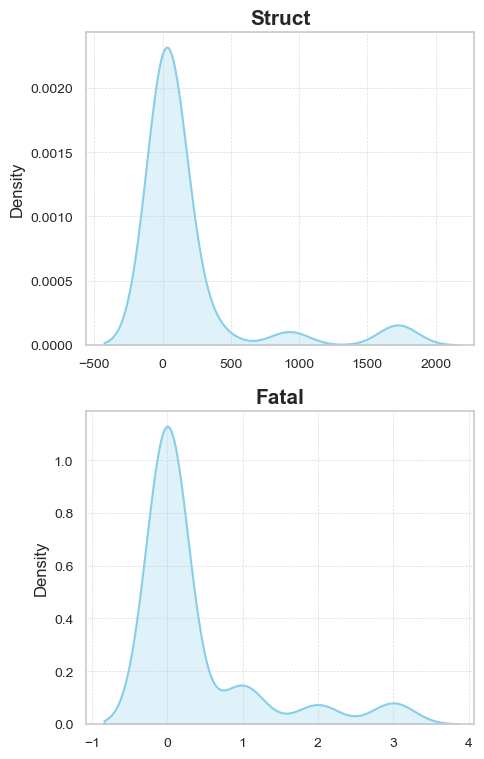

In [5]:
final['Struct'] = final['Dam.'] + final['Dest.']
final['Fatal'] =  final['Fire'] + final['Civil']

damage_measures = ['Struct', 'Fatal']

non_zero = final[(final[damage_measures] > 0).any(axis=1)].index

for col in damage_measures:
    upper_cap = final.loc[non_zero, damage_measures].quantile(0.95)
    final.loc[non_zero, damage_measures] = final.loc[non_zero, damage_measures].clip(upper=upper_cap,axis=1)
    
grid_kde(final.loc[non_zero, damage_measures])

In [6]:
scaler = MinMaxScaler()
final.loc[non_zero, damage_measures] = scaler.fit_transform(final.loc[non_zero, damage_measures])

scaled_df = pd.DataFrame(
    scaled,
    columns=['Total_scaled','Dam_scaled', 'Dest_scaled', 'Fire_scaled', 'Civil_scaled'],
    index=final.index  # keep alignment with original DataFrame
)

In [7]:
final['WDFI'] = (
    1 * final['Struct'] +
    10 * final['Fatal']
)

In [8]:
final.loc[non_zero,'WDFI'].describe()

count    216.000000
mean       1.335447
std        2.916125
min        0.000000
25%        0.001742
50%        0.010453
75%        0.251452
max       11.000000
Name: WDFI, dtype: float64

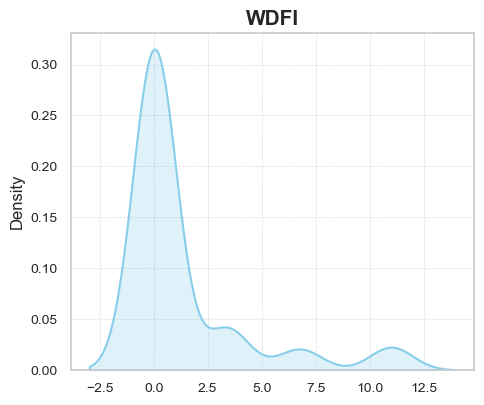

In [9]:
subset = final.loc[non_zero,:]
grid_kde(subset[['WDFI']])

### 1.2 Creating a Categorical Index for Fire Severity

The target variable is initially categorized into three classes based on **days burned** and **WDFI (Wildfire Danger Fire Index)** values:

- **Low**: Days with **no fire activity** (days burned = 0).

- **Moderate**: Days with **at least one day burned** and **WDFI below the mean** WDFI value across all fire days.

- **High**: Days with **at least one day burned** and **WDFI above the mean** WDFI value across all fire days.

This classification helps the model distinguish between no-fire days, moderately destructive fire days, and highly destructive fire days.

In [10]:
# Define conditions
cond_low = (final['Days'] == 0)
cond_mod = (final['Days'] > 0) & (final['WDFI'] < final.loc[non_zero,'WDFI'].mean())
cond_high = ~(cond_low | cond_mod)  # Everything else

# Define choices
choices = ['Low', 'Moderate', 'High']

# Apply conditions
final['Target'] = np.select(
    [cond_low, cond_mod, cond_high],
    choices,
    default='Unknown'  # Optional fallback
)


In [11]:
print('Initial distribution of classification by number of days: \n', final['Target'].value_counts())

Initial distribution of classification by number of days: 
 Target
Low         99115
Moderate      557
High           45
Name: count, dtype: int64


#### Note
Some fires caused minimal structural damage but burned a large amount of acres. Any fire **greater than 5000 acres** is reclassified as highly destructive.

subset = final[final['Total'] > 5000].index
final.loc[subset,['Target']] = 'High'

In [12]:
print('Final distribution of classification by number of days: \n', final['Target'].value_counts())

Final distribution of classification by number of days: 
 Target
Low         99115
Moderate      557
High           45
Name: count, dtype: int64


### 1.3 Spread Category Over Fire Duration

Spread the severity category across all days that a fire burned (not just the start date).

In [13]:
final['Days'].sum() - len(final[final['Days']>0])

10292.0

In [14]:
stations = final['Stn Id'].unique()
subset = final[final['Stn Id'] == stations[0]]

for station in stations:
    subset = final[final['Stn Id'] == station].index
    last = subset.max()
    
    for index in subset:
        days = int(final.loc[index,'Days'])
        
        for i in range(days):
            if ((index + i) != last):
                final.loc[index + i,'Target'] = final.loc[index,'Target']

In [15]:
example_idx = final[final['Days'] > 2].index
days = int(final.loc[example_idx[0], 'Days'])
target_val = final.loc[example_idx[0], 'Target']
print(final.loc[example_idx[0] : example_idx[0] + days, ['Target', 'Days']])

       Target  Days
188  Moderate   7.0
189  Moderate   0.0
190  Moderate   0.0
191  Moderate   0.0
192  Moderate   0.0
193  Moderate   0.0
194  Moderate   0.0
195       Low   0.0


In [16]:
print('Final distribution of classification by number of days: \n', final['Target'].value_counts())

Final distribution of classification by number of days: 
 Target
Low         90736
Moderate     7625
High         1356
Name: count, dtype: int64


### 1.4 Visualize final distribution

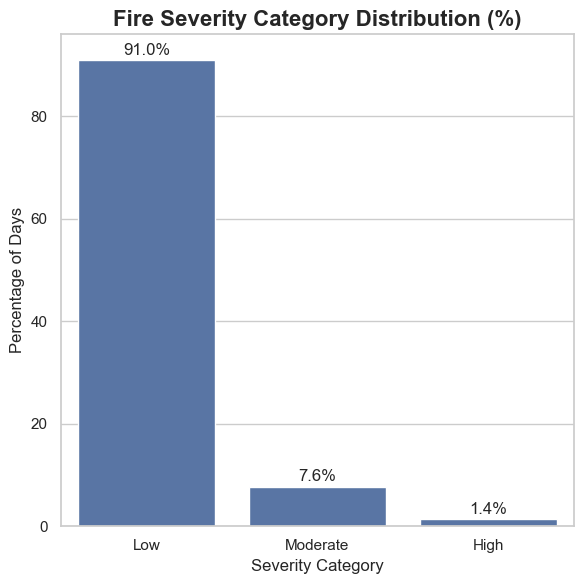

In [17]:
# Calculate percentage values
category_percent = (
    final['Target']
    .value_counts(normalize=True)
    .reindex(['Low', 'Moderate', 'High']) * 100
)

# Bar plot of percentages using default Seaborn colors
plt.figure(figsize=(6, 6))
sns.barplot(
    x=category_percent.index,
    y=category_percent.values
)

# Add percentage labels
for i, pct in enumerate(category_percent):
    plt.text(i, pct + 0.5, f"{pct:.1f}%", ha='center', va='bottom', fontsize=12)

plt.title('Fire Severity Category Distribution (%)', fontsize=16, weight='bold')
plt.xlabel('Severity Category')
plt.ylabel('Percentage of Days')
plt.ylim(0, category_percent.max() + 5)
plt.tight_layout()
plt.show()

## 2. Feature Exploration and Selection

This section visualizes key environmental variables to assess their relationships with wildfire severity categories. Based on the `Categorical Index`, we explore how different weather features interact and influence fire risk.

### 2.1 Seperate target and independent variables

In [18]:
final_details = final[['class', 'WDFI','Stn Id','Latitude','Longitude','Target',
                       'Stn Name','CIMIS Region','Date','County','_merge']]

filtered = final.drop(columns = ['Dest.','Dam.','Fire','Total','Civil','Days','Struct','Fatal',
                                 'class','WDFI','Stn Id','Latitude','Longitude',
                                 'Target','Stn Name','CIMIS Region','Date','OBJECTID','County','_merge'])

In [19]:
custom_map = {'Low':0,'Moderate':1,'High':2}
#filtered['Target'] = final['Target']
filtered['Target Index'] = final['Target'].map(custom_map)

# Define a consistent order for categorical severity labels (used in plotting)
custom_order = ['Low', 'Moderate', 'High']

In [20]:
filtered['Target Index'].unique()

array([0, 1, 2], dtype=int64)

### Note  
To reduce dataset size and simplify analysis, the following steps were taken:  
- Dropped **Min** and **Max Air Temperature**, retained **Average Air Temperature**  
- Dropped **Min** and **Max Relative Humidity**, retained **Average Relative Humidity**

In [21]:
drop = ['Max Air Temp (F)','Min Air Temp (F)','Max Rel Hum (%)','Min Rel Hum (%)', 'Target Index']
drop

['Max Air Temp (F)',
 'Min Air Temp (F)',
 'Max Rel Hum (%)',
 'Min Rel Hum (%)',
 'Target Index']

### 4.2 DIrect Water Demand Indicators

`ETo (in)` - Evapotranspiration is a measure of how much water is lost to the atmosphere
`Sol Rad (Ly/day)` - A measure of sunlight recieved
`Avg Vap Pres (mBars)`
`Dew Point (F)`

In [22]:
water_demand = ['ETo (in)', 'Sol Rad (Ly/day)', 'Avg Air Temp (F)', 'Avg Wind Speed (mph)', 
                'Avg Soil Temp (F)','Wind Run (miles)', 'Target Index']

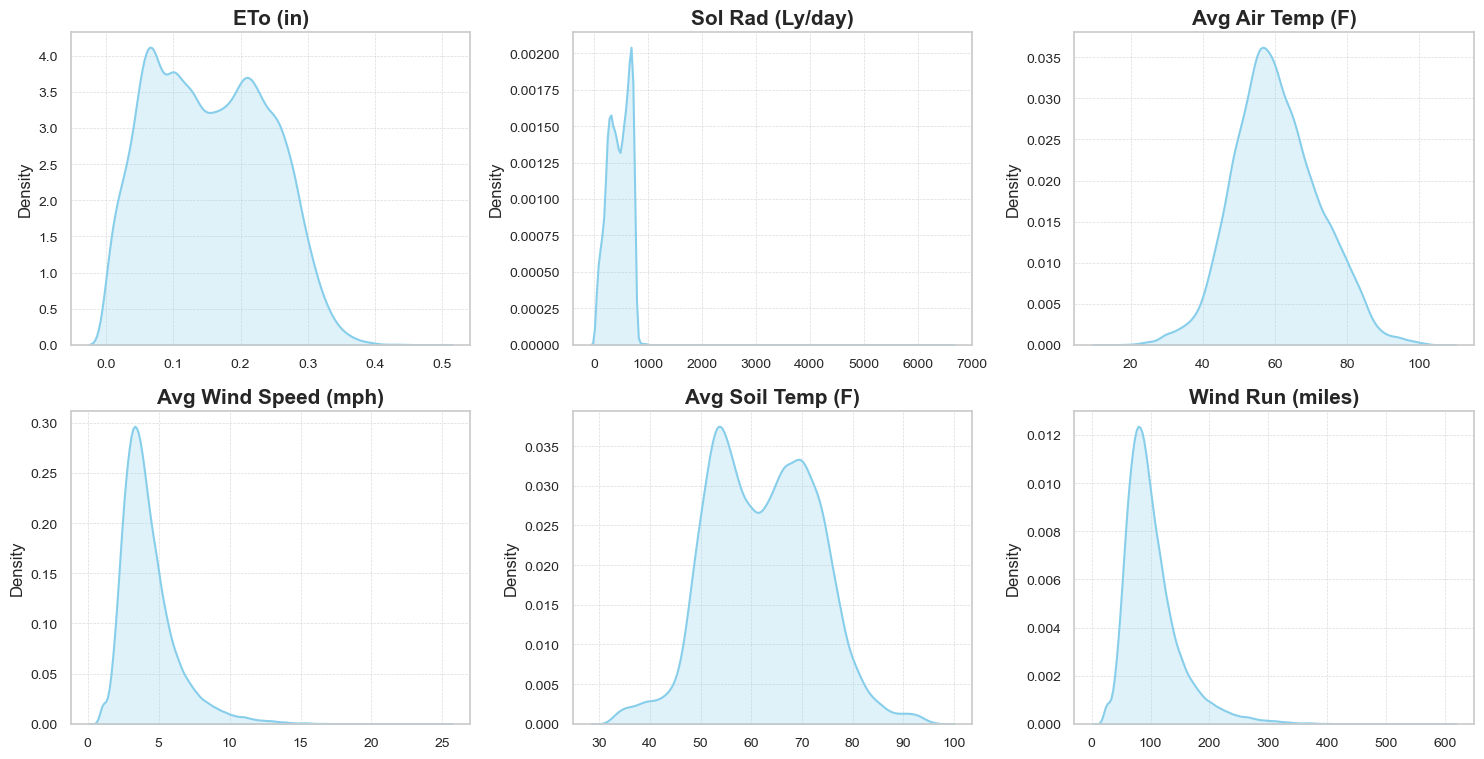

In [23]:
grid_kde(filtered[water_demand].drop(columns='Target Index'))

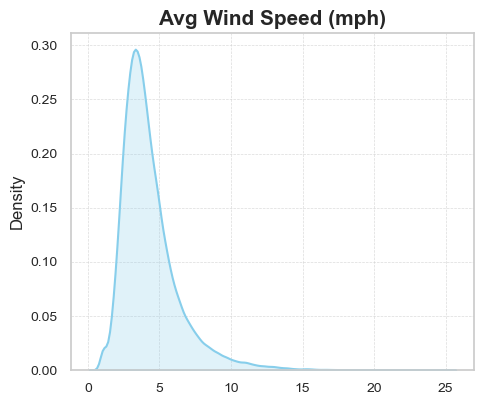

In [24]:
filtered['Avg Wind Speed (mph)'] = filtered['Avg Wind Speed (mph)'].clip(upper=400)

grid_kde(filtered[['Avg Wind Speed (mph)']])

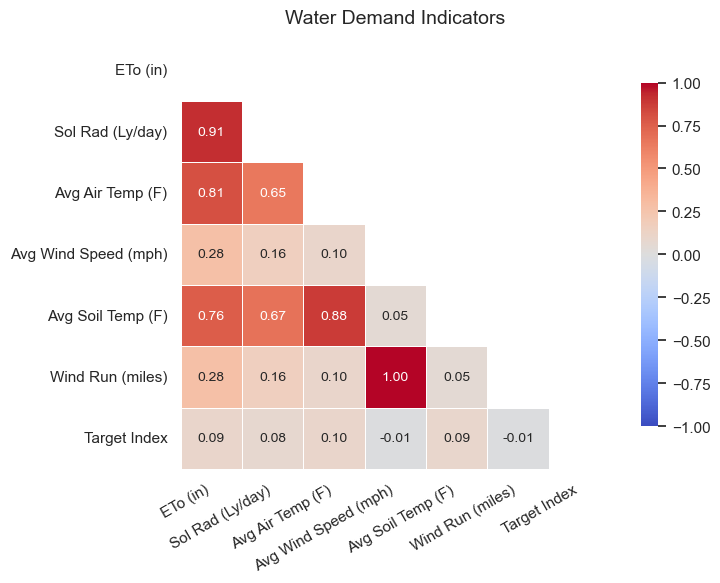

In [25]:
correlation_map(filtered[water_demand],'Water Demand Indicators')

#### Key Insights: Water Demand Variables

- **Evapotranspiration (ETo)** and **Solar Radiation** show a strong positive correlation, indicating shared influence from sunlight and temperature — both crucial in assessing vegetation moisture loss.
  
- **Dew Point** and **Vapor Pressure** are highly correlated, suggesting they provide overlapping information. These variables reflect atmospheric moisture content and may be redundant in modeling.

- Together, these indicators are effective in representing **vegetation dryness**, a critical factor in estimating wildfire ignition and spread potential.

- `ETO` and `Avg Vapor Pressure` are more correllated with target


#### Colinearity examination

<Axes: xlabel='ETo (in)', ylabel='Sol Rad (Ly/day)'>

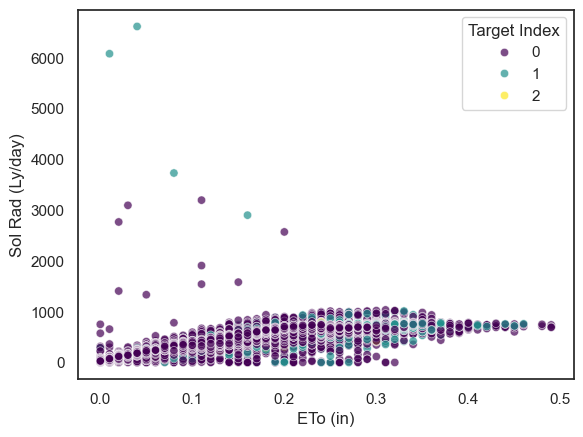

In [26]:
sns.scatterplot(
    x='ETo (in)', y='Sol Rad (Ly/day)', hue='Target Index', data=filtered, 
    hue_order=custom_order, palette='viridis', alpha=0.7
)

#### Key Findings

- **Evapotranspiration (ETo)** and **Solar Radiation** showed a **strong positive correlation**, indicating that days with high solar energy also tend to have greater evaporative demand. This aligns with meteorological understanding and highlights both as valuable indicators of fuel dryness.

- **Dew Point Temperature** and **Average Vapor Pressure (mBars)** were found to be **highly collinear**, suggesting redundancy. Both variables capture atmospheric moisture content, and including both could introduce multicollinearity issues into modeling.

#### Visual Insights

- The **ETo vs. Solar Radiation** scatter plot showed a clear separation of severity categories, especially for more extreme fire days, supporting its predictive utility.

- The **Dew Point vs. Vapor Pressure** plot showed strong linear association between the two, but limited separation between severity classes, further supporting removal of one.

<Axes: xlabel='Avg Wind Speed (mph)', ylabel='Wind Run (miles)'>

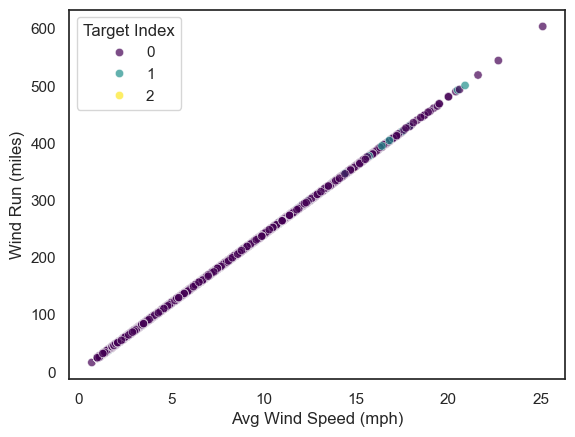

In [27]:
sns.scatterplot(
    x='Avg Wind Speed (mph)', y='Wind Run (miles)', hue='Target Index', data=filtered,
    hue_order=custom_order, palette='viridis', alpha=0.7
)

<Axes: xlabel='Avg Soil Temp (F)', ylabel='Avg Air Temp (F)'>

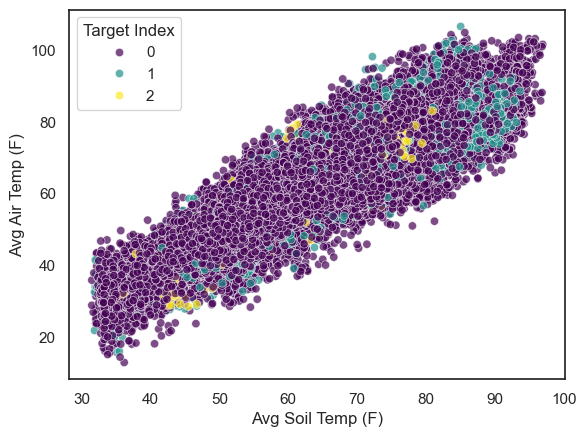

In [28]:
sns.scatterplot(
    x='Avg Soil Temp (F)', y='Avg Air Temp (F)', hue='Target Index', data=filtered,
    hue_order=custom_order, palette='viridis', alpha=0.7
)

In [29]:
drop.extend(['Wind Run (miles)'])
drop

['Max Air Temp (F)',
 'Min Air Temp (F)',
 'Max Rel Hum (%)',
 'Min Rel Hum (%)',
 'Target Index',
 'Wind Run (miles)']

### 4.3 Water Supply Indicators

In [30]:
water_supply = ['Precip (in)', 'Avg Rel Hum (%)', 'Avg Vap Pres (mBars)', 'Dew Point (F)', 'Target Index']

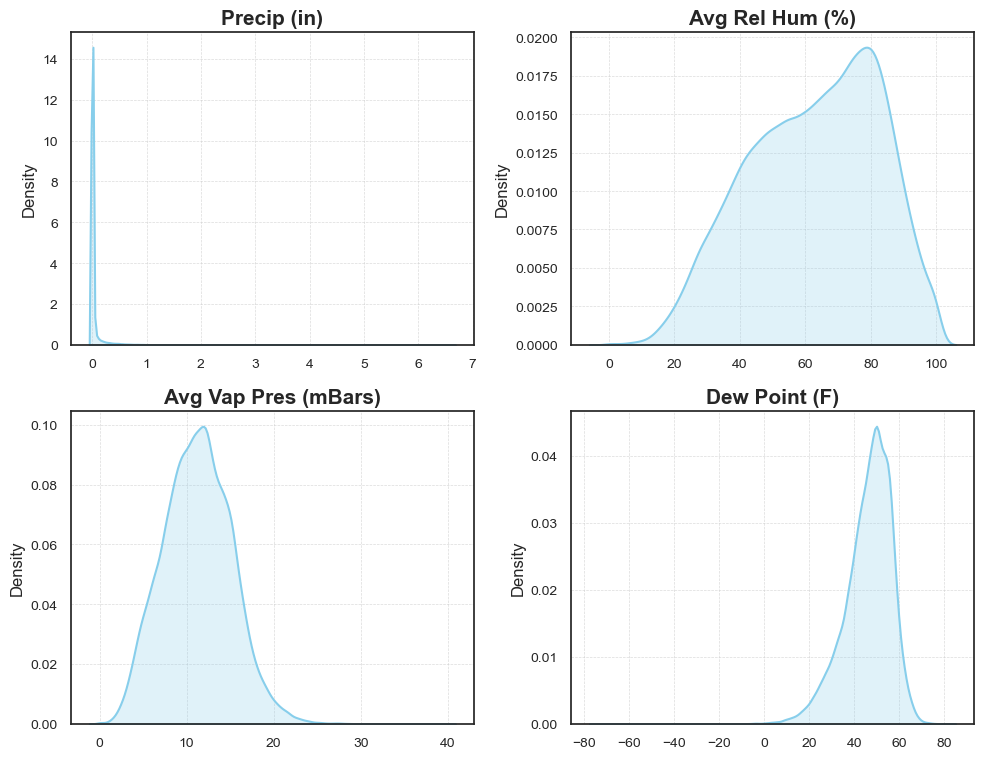

In [31]:
grid_kde(filtered[water_supply].drop(columns='Target Index'))

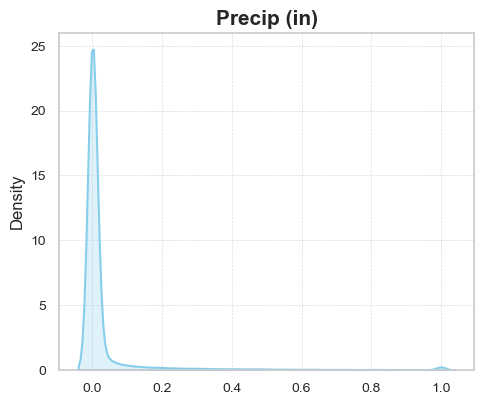

In [32]:
filtered['Precip (in)'] = filtered['Precip (in)'].clip(upper=1)

grid_kde(filtered[['Precip (in)']])

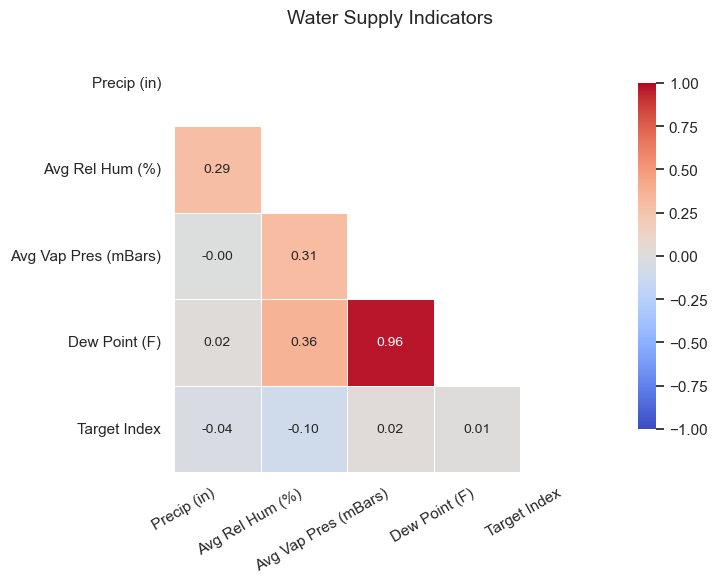

In [33]:
correlation_map(filtered[water_supply],'Water Supply Indicators')

#### Precipitation and Humidity Indicators – Key Insights

- **Strong Correlation Between Daily and Averaged Values**  
  As expected, daily values and their 7-day rolling averages (e.g., `Precip (in)` and `Precip (in) 7 Day Avg`) are highly correlated. This confirms that the rolling metrics are stable reflections of short-term conditions and may be more useful in reducing noise during modeling.

- **Inverse Relationship with Fire Severity**  
  Both precipitation and relative humidity indicators are **negatively correlated** with the categorical fire risk index. This aligns with domain expectations—**drier and less humid conditions correspond to higher wildfire severity**.

- These findings support the inclusion of **`7-day average precipitation` and `7-day average relative humidity`** in the final model, while the single-day values may be excluded to reduce redundancy.

- Drop `Avg Rel Hum (%)`



<Axes: xlabel='Avg Vap Pres (mBars)', ylabel='Dew Point (F)'>

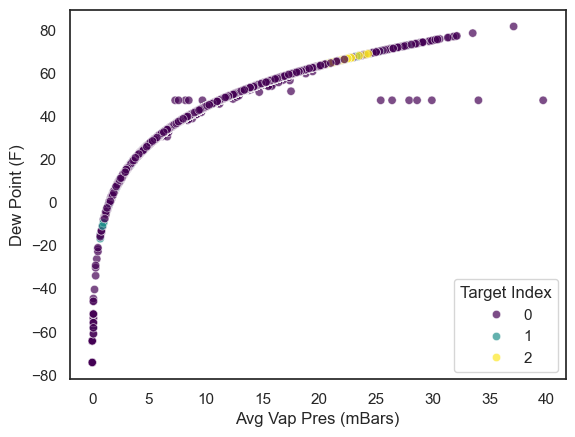

In [34]:
sns.scatterplot(
    x='Avg Vap Pres (mBars)', y='Dew Point (F)', hue='Target Index', data=filtered, 
    hue_order=custom_order, palette='viridis', alpha=0.7
)

Drop Dew Point due to *colinearity* with vapor pressure and less correlation with index

In [35]:
drop.extend(['Dew Point (F)'])
drop

['Max Air Temp (F)',
 'Min Air Temp (F)',
 'Max Rel Hum (%)',
 'Min Rel Hum (%)',
 'Target Index',
 'Wind Run (miles)',
 'Dew Point (F)']

## 3. Feature Engineering

This section constructs a wildfire Severity Index from various damage metrics, and categorizes fire severity for modeling.

### 3.1 Dryness Indicator

PET_proxy = a * T_mean + b * Wind + c * SolarRadiation - d * Humidity

In [36]:
final['Dryness'] = calculate_dryness_index(final).astype(float)
palisades_weather['Dryness'] = calculate_dryness_index(palisades_weather)
dixie_weather['Dryness'] = calculate_dryness_index(dixie_weather)

#final['Dryness'] = pd.qcut(final['Dryness'], q=3, labels=[0, 1, 2])

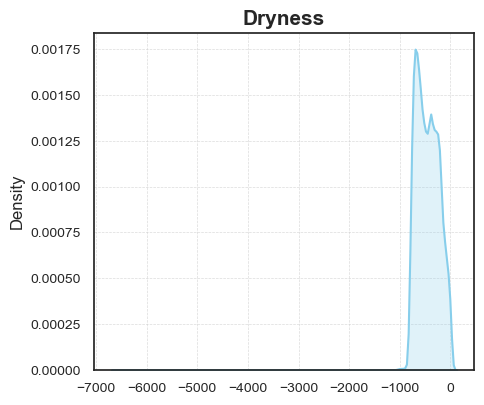

In [37]:
grid_kde(final[['Dryness']])

### 3.2 Add Lagged Weather Variables

We calculate 7-day rolling averages for select weather variables to capture recent trends that may influence fire severity.

In [38]:
# Sort data by County and Date to prepare for rolling average
final = final.sort_values(by=['County', 'Date'])
pal_filtered = palisades_weather.sort_values(by=['County', 'Date'])
dixie_filtered = dixie_weather.sort_values(by=['County', 'Date'])

# Define columns for 7-day rolling average
avg_columns = [
    'Avg Air Temp (F)', 
    'Precip (in)',
    'Avg Rel Hum (%)', 
    'Avg Wind Speed (mph)'
]

# Apply rolling mean by County
for col in avg_columns:
    final[f'{col} 7 Day Avg'] = final.groupby('County')[col].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
    pal_filtered[f'{col} 7 Day Avg'] = pal_filtered.groupby('County')[col].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
    dixie_filtered[f'{col} 7 Day Avg'] = dixie_filtered.groupby('County')[col].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

## 4.4 Feature Interaction Analysis

In [39]:
pal_filtered = pal_filtered.dropna()
dixie_filtered = dixie_filtered.dropna()

In [40]:
case_details = ['Date', 'Stn Name', 'County', 'CIMIS Region','Latitude','Longitude']

# Store identifying metadata for later use (not used in modeling)
pal_details = pal_filtered[case_details]
dixie_details = dixie_filtered[case_details]

#case_study_cols = [col for col in drop if col not in ['Target Index']]
#case_study_drop = ['Date','Stn Name','County','CIMIS Region','Stn Id','Jul','OBJECTID','Name','class']

In [41]:
y = filtered['Target Index']
X = filtered.drop(columns = drop)

pal_X = pal_filtered[X.columns]
#pal_X = pal_X.drop(columns = case_study_drop)

dixie_X = dixie_filtered[X.columns]
#dixie_X = dixie_X.drop(columns = case_study_drop)

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scales and returns a NumPy array
pal_X_scaled = scaler.fit_transform(pal_X)
dixie_X_scaled = scaler.fit_transform(dixie_X)

In [43]:
# Optionally convert back to DataFrame with same columns and index:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
pal_X_scaled = pd.DataFrame(pal_X_scaled, columns=pal_X.columns, index=pal_X.index)
dixie_X_scaled = pd.DataFrame(dixie_X_scaled, columns=dixie_X.columns, index=dixie_X.index)

In [44]:
inter_X = create_2nd_degree_interactions(X_scaled)
inter_pal_X = create_2nd_degree_interactions(pal_X_scaled)
inter_dixie_X = create_2nd_degree_interactions(dixie_X_scaled)

In [45]:
inter_X_combined = pd.concat([X_scaled, inter_X], axis=1)
inter_pal_X_combined = pd.concat([pal_X_scaled, inter_pal_X], axis=1)
inter_dixie_X_combined = pd.concat([dixie_X_scaled, inter_dixie_X], axis=1)

In [46]:
correlation_results = rank_interactions_by_correlation(inter_X_combined, y)
keep = correlation_results.head(20)['Feature'].tolist()

In [47]:
correlation_results.head(20)

,Feature,Correlation
0,Mean Income,-0.152526
1,Total Population x Mean Income,0.126885
2,Avg Rel Hum (%),-0.101407
3,Avg Air Temp (F),0.096809
4,ETo (in),0.093763
5,Elevation,0.093016
6,Avg Soil Temp (F),0.092185
7,Size (square miles),0.079727
8,Sol Rad (Ly/day),0.076319
9,density,-0.061489


In [48]:
X = inter_X_combined[keep]
pal_X = inter_pal_X_combined[keep]
dixie_X = inter_dixie_X_combined[keep]

## 5. Scale Data

In [49]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale training and prediction datasets
scaled_X = scaler.fit_transform(X)
scaled_pal_X = scaler.fit_transform(pal_X)
scaled_dixie_X = scaler.fit_transform(dixie_X)

# Reconstruct scaled data into DataFrames
X = pd.DataFrame(scaled_X, columns=X.columns)
pal_X = pd.DataFrame(scaled_pal_X, columns=pal_X.columns)
dixie_X = pd.DataFrame(scaled_dixie_X, columns=pal_X.columns)

## Export Feature Data

In [50]:
X.to_csv('../data/processed/X.csv', index=False)
pal_X.to_csv('../data/processed/pal_X.csv', index=False)
dixie_X.to_csv('../data/processed/dixie_X.csv', index=False)
y.to_csv('../data/processed/y.csv', index=False)
pal_details.to_csv("../data/processed/pal_details.csv", index=False)
dixie_details.to_csv("../data/processed/dixie_details.csv", index=False)
print("All datasets saved successfully to ../data/processed/")

All datasets saved successfully to ../data/processed/
